In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
data = pd.read_csv("../data/marketing_campaign.csv", sep="\t")
data.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
data = data.dropna()
print(f"Количество объектов после удаления пропусков: {data.shape[0]}")

Количество объектов после удаления пропусков: 2216


In [7]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True) 
dt_max = data["Dt_Customer"].max()
dt_min = data["Dt_Customer"].min()
print(f"Дата добавления последнего покупателя в базу: {dt_max}")
print(f"Дата добавления первого покупателя в базу: {dt_min}")

Дата добавления последнего покупателя в базу: 2014-06-29 00:00:00
Дата добавления первого покупателя в базу: 2012-07-30 00:00:00


In [8]:
data["Customer_For"] = dt_max - data["Dt_Customer"] 
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [9]:
data["Age"] = 2014-data["Year_Birth"]

data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Здесь есть значения, которые надо перевести в значения Alone или Parthner для бинаризации признака
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

data["Children"]=data["Kidhome"]+data["Teenhome"]

data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Удалим использованные признаки
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [10]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_For  \
count   2216.000000   2216.000000  2216.000000  2216.000000  2.216000e+03   
mean       0.064079      0.013538     0.009477     0.150271  3.054423e+16   
std        0.244950      0.115588     0.096907     0.357417  1.749036e+16   
min        0.000000      0.000000     0.000000     0.000000  0.000000e+00   
25%        0.000000      0.000000     0.000000     0.000000  1.555200e+16   
50%        0.000000      0.000000     0.000000     0.000000  3.071520e+16   
75%        0.000000      0.000000     0.000000     0.000000  4.570560e+16   
max        1.000000      1.000000     1.000000     1.000000  6.039360e+16   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     45.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      18.000000     5.000000     0.000000     1.000000     0.000000  
25%      37.000000    69.000000     0.000000     2.000000     0.000000  
50%      44.000000   396.500000     1.000000     3.000000     1.000000  
75%      55.000000  1048.000000     1.000000     3.000000     1.000000  
max     121.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   Wines                2212 non-null   int64  
 6   Fruits               2212 non-null   int64  
 7   Meat                 2212 non-null   int64  
 8   Fish                 2212 non-null   int64  
 9   Sweets               2212 non-null   int64  
 10  Gold                 2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisitsMonth    2212 non-null   int64 

<Figure size 800x550 with 0 Axes>

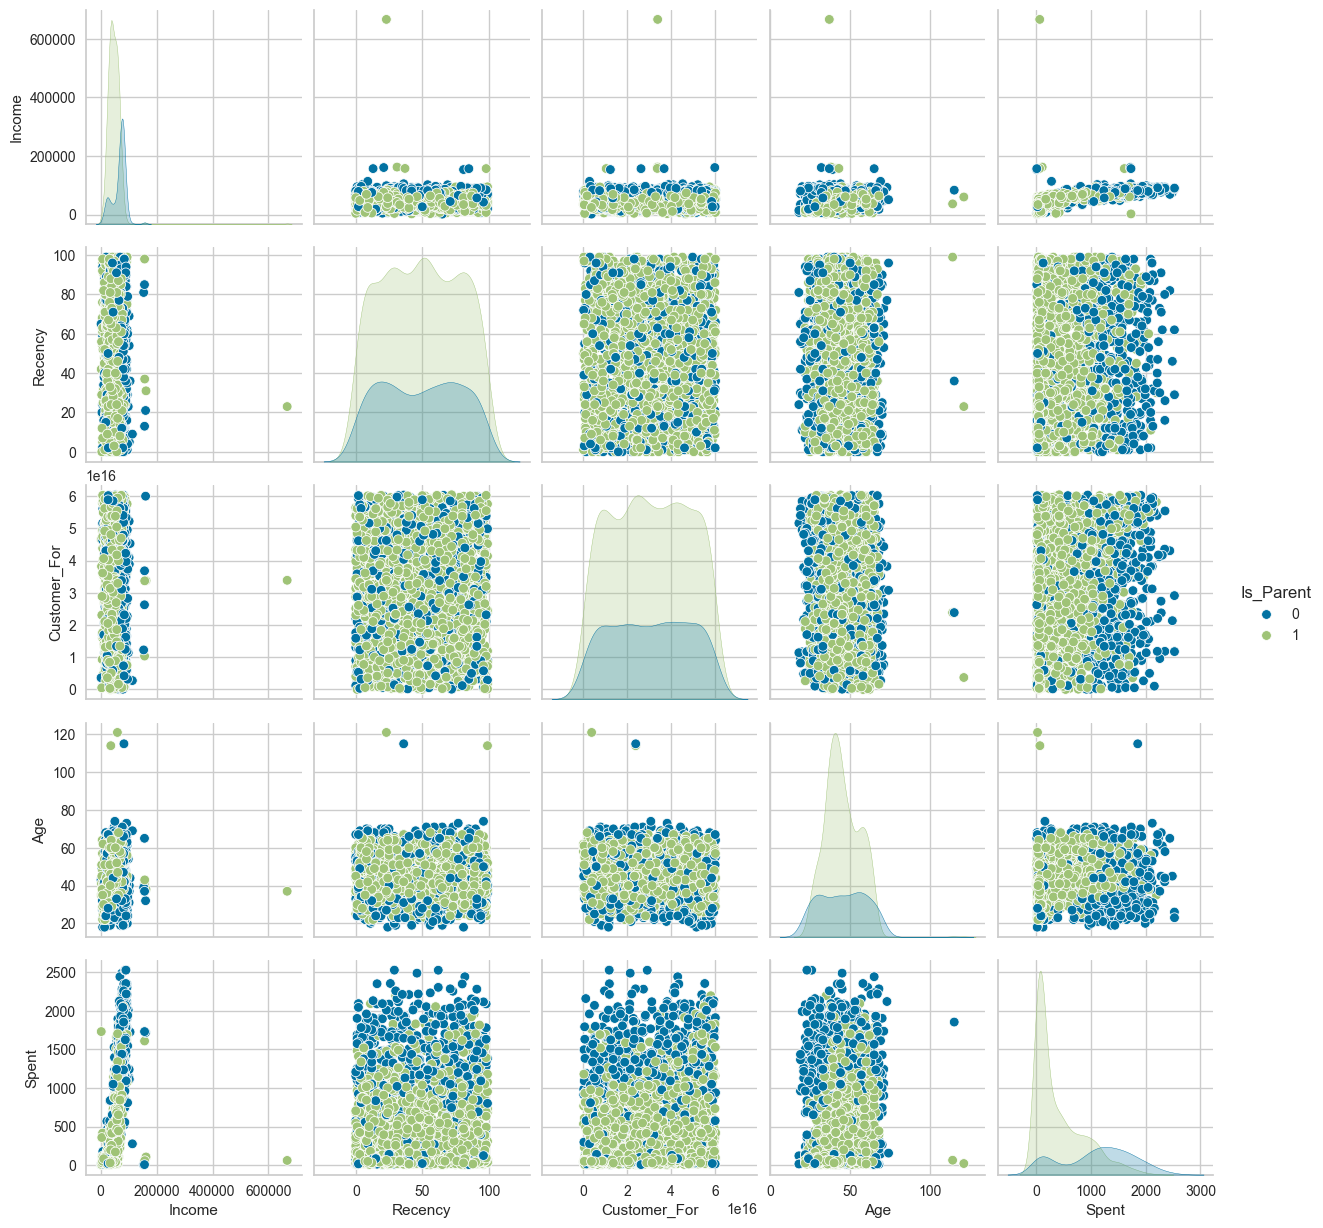

In [11]:
to_plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
plt.figure()
sns.pairplot(data[to_plot], hue= "Is_Parent")
plt.show()

In [12]:
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print(f"Количество объектов после удаления выбросов: {data.shape[0]}")

Количество объектов после удаления выбросов: 2212


<Axes: >

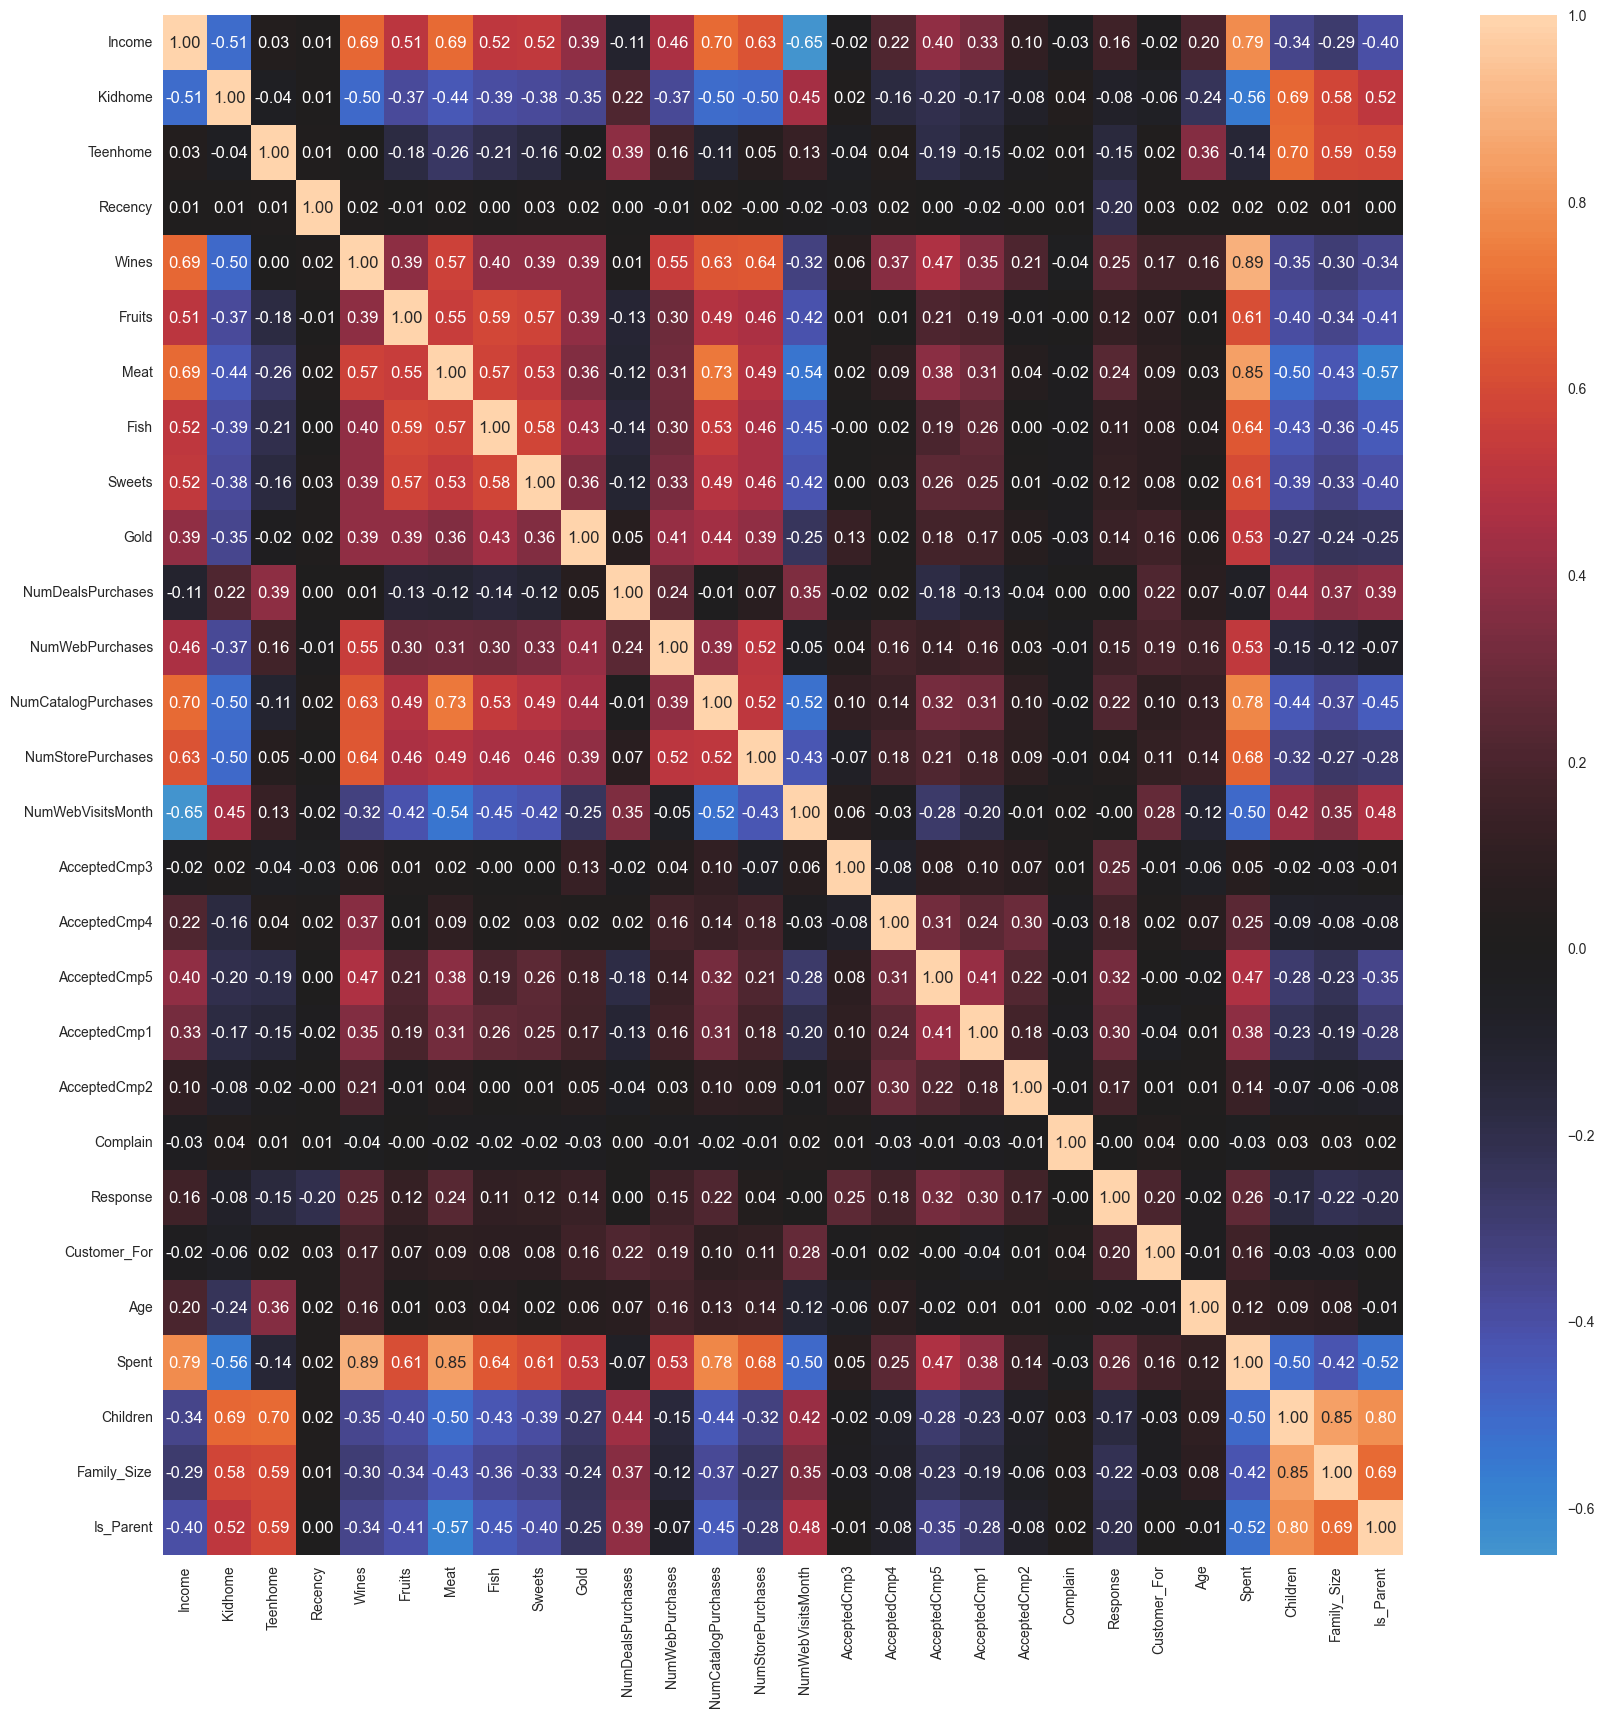

In [15]:
dt = data.drop(['Education', 'Living_With'], axis=1)
plt.figure(figsize=(20,20))  
sns.heatmap(dt.corr(),fmt='.2f',annot=True, center=0)

In [16]:
LE = LabelEncoder()
data['Education'] = LE.fit_transform(data['Education'])
data['Living_With'] = LE.fit_transform(data['Living_With'])


#сделаем копию данных
ds = data.copy()
# удалим бинарные признаки
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )


#Посмотрим на датасет, который будем использовать для дальнейшей кластеризации
scaled_ds.head()

Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.690293  2.453472  1.483713  ...             2.503607          -0.555814   
1 -0.718230 -0.651004 -0.634019  ...            -0.571340          -1.171160   
2 -0.178542  1.339513 -0.147184  ...            -0.229679           1.290224   
3 -0.655787 -0.504911 -0.585335  ...            -0.913000          -0.555814   
4 -0.218684  0.152508 -0.001133  ...             0.111982           0.059532   

   NumWebVisitsMonth  Customer_For       Age     Spent  Living_With  Children  \
0           0.692181      1.527721  1.018352  1.676245    -1.349603 -1.264598   
1          -0.132545     -1.189011  1.274785 -0.963297    -1.349603  1.404572   
2          -0.544908     -0.206048  0.334530  0.280110     0.740959 -1.264598   
3           0.279818     -1.060584 -1.289547 -0.920135     0.740959  0.069987   
4          -0.132545     -0.951915 -1.033114 -0.307562     0.740959  0.069987   

   Family_Size  Is_Parent  
0    -1.758359  -1.581139  
1     0.449070   0.632456  
2    -0.654644  -1.581139  
3     0.449070   0.632456  
4     0.449070   0.632456  

[5 rows x 23 columns]

In [17]:
pca = PCA(n_components=3)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  8.994212e-17  2.878602 -5.978124 -2.539470 -0.781595  2.386380   
col2  2212.0  4.497106e-17  1.709469 -4.194757 -1.323929 -0.173721  1.234851   
col3  2212.0  2.730386e-17  1.231687 -3.625248 -0.853713 -0.050842  0.863974   

           max  
col1  7.452915  
col2  6.168189  
col3  6.750458

In [18]:
x,y,z = PCA_ds["col1"],PCA_ds["col2"],PCA_ds["col3"]

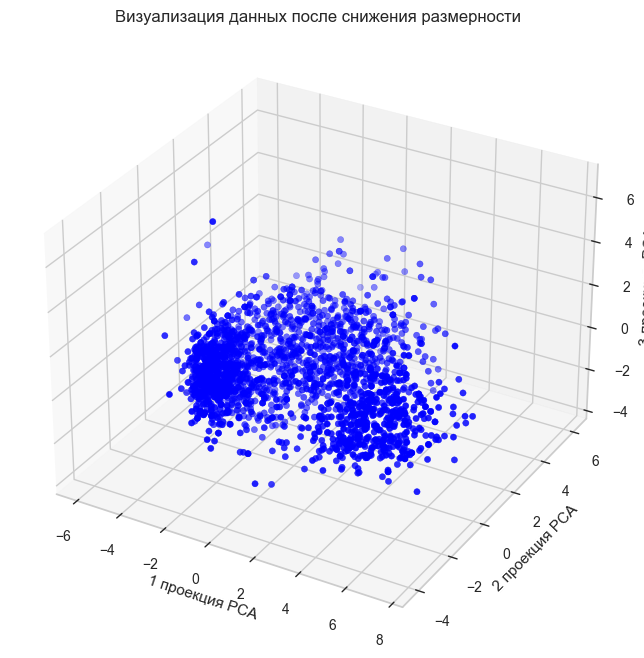

In [19]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("Визуализация данных после снижения размерности")
ax.set_xlabel('1 проекция PCA')
ax.set_ylabel('2 проекция PCA')
ax.set_zlabel('3 проекция  PCA')
plt.show()

In [20]:
pal = ["y","g", "b","r"]
#код для создания своей color map,для использование напрямую как значение параметра cmap которую далее будем использовать. 
cmap = colors.ListedColormap(["y","g", "b","r"])

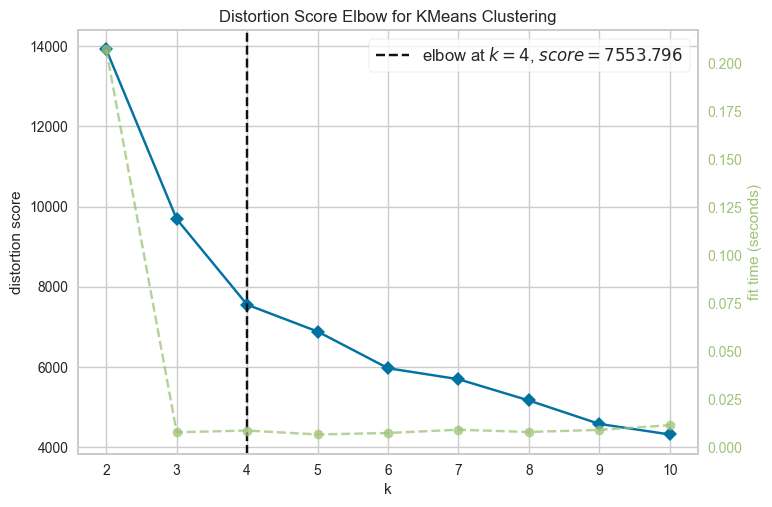

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [22]:
model = KMeans(n_clusters=4)
y_pred = model.fit_predict(PCA_ds)
PCA_ds["Clusters"] = y_pred
data["Clusters"]= y_pred

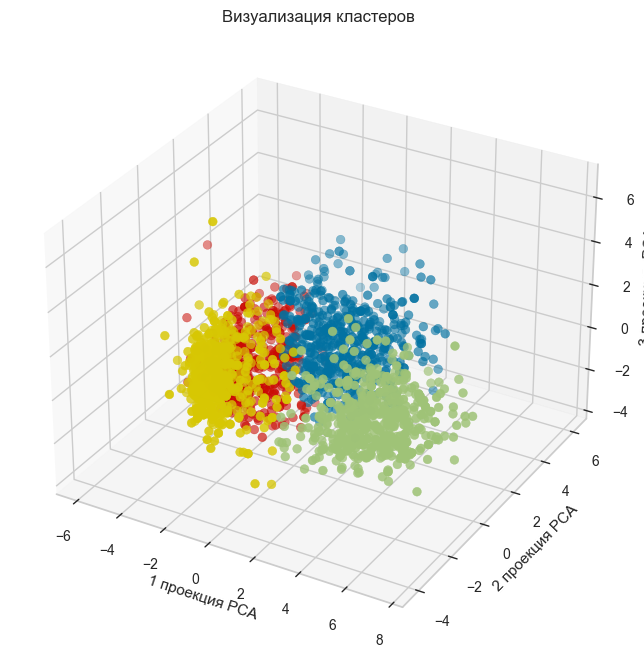

In [23]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"],cmap=cmap, marker='o')
ax.set_title("Визуализация кластеров")
ax.set_xlabel('1 проекция PCA')
ax.set_ylabel('2 проекция PCA')
ax.set_zlabel('3 проекция  PCA')
plt.show()

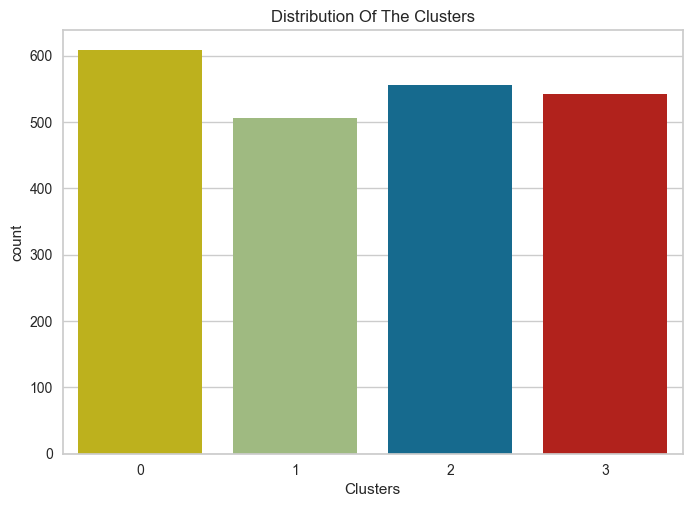

In [24]:
pl = sns.countplot(x=data["Clusters"], palette=pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

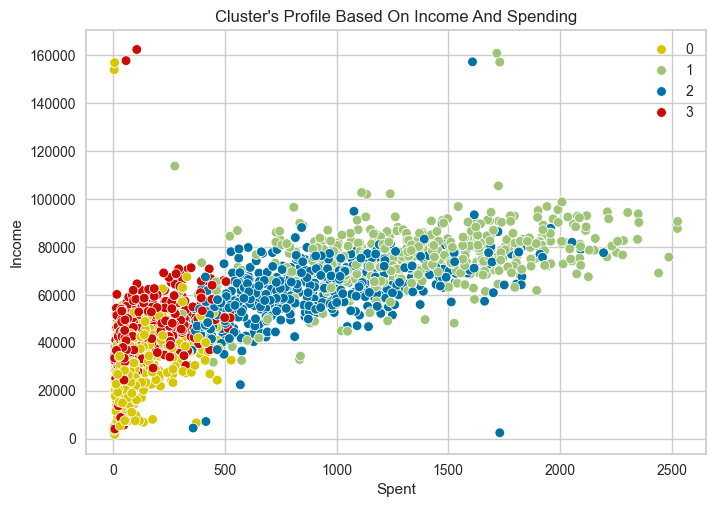

In [25]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"],palette=pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

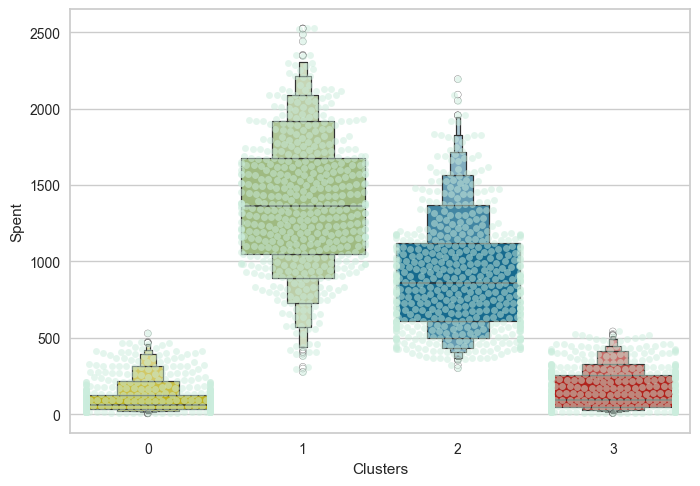

In [26]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

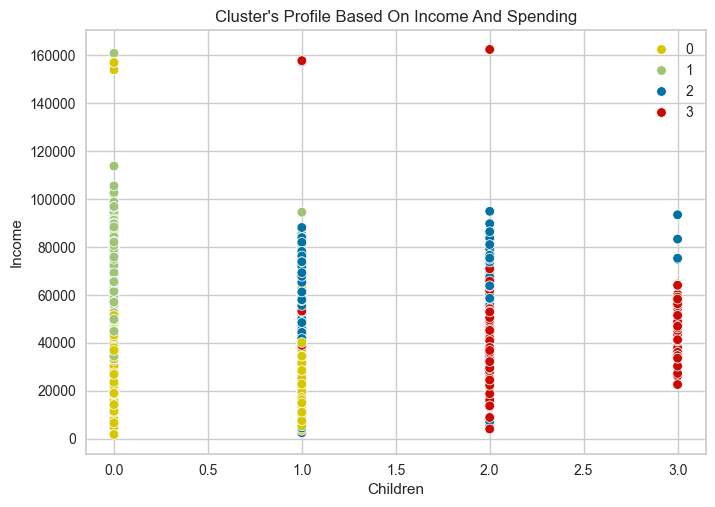

In [54]:
pl = sns.scatterplot(data = data,x=data["Children"], y=data["Income"],hue=data["Clusters"],palette=pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

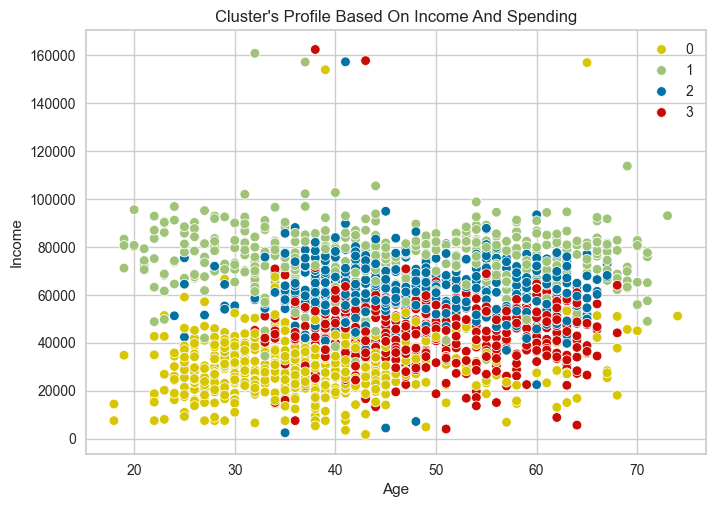

In [55]:
pl = sns.scatterplot(data = data,x=data["Age"], y=data["Income"],hue=data["Clusters"],palette=pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

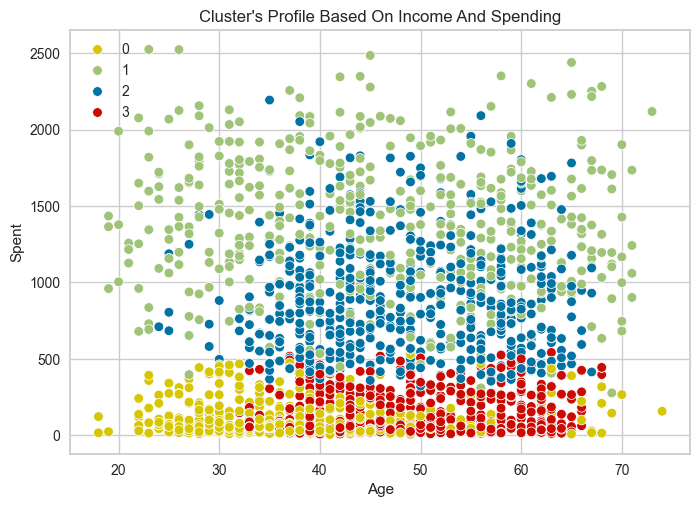

In [56]:
pl = sns.scatterplot(data = data,x=data["Age"], y=data["Spent"],hue=data["Clusters"],palette=pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

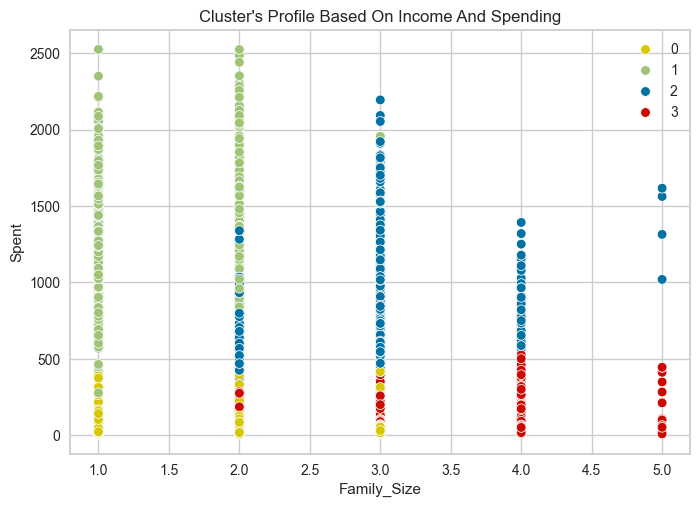

In [57]:
pl = sns.scatterplot(data = data,x=data["Family_Size"], y=data["Spent"],hue=data["Clusters"],palette=pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

# Task

In [27]:
task_data= pd.read_csv("../data/CC GENERAL.csv")
print(task_data.shape)
task_data.head()

(8950, 18)


CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [28]:
task_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [29]:
task_data['MINIMUM_PAYMENTS'].isna().sum()

np.int64(313)

In [31]:
task_data.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

In [33]:
task_data.loc[(task_data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=task_data['MINIMUM_PAYMENTS'].mean()
task_data.loc[(task_data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']= task_data['CREDIT_LIMIT'].mean() 

In [34]:
task_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [38]:
def add_range(df, columns, range_list, onesided = True):
    for column in columns:
        name = column + '_range'
        df[name] = 0
        for i in range(len(range_list)-1):
            df.loc[(df[column] > range_list[i])&(df[column] <= range_list[i+1]), name] = i+1
            if onesided:
                df.loc[(df[column] >range_list[-1]), name] = len(range_list)
    df.drop(columns, axis = 1, inplace = True)

In [40]:
add_range(task_data,['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS'], [0,500,1000,3000,5000,10000])

add_range(task_data,['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT'] , np.linspace(0,1,11),onesided=False)

add_range(task_data,['PURCHASES_TRX', 'CASH_ADVANCE_TRX'] ,[0,5,10,15,20,30,50,100] ,onesided=False)


In [ ]:
task_data.drop(['CUST_ID'], axis=1, inplace=True)

X= np.asarray(task_data)

In [47]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

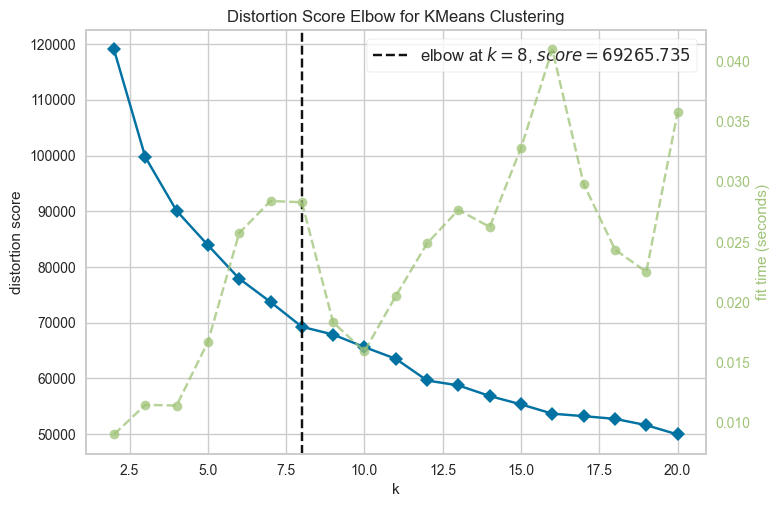

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
Elbow_M = KElbowVisualizer(KMeans(), k=20)
Elbow_M.fit(X)
Elbow_M.show()

In [62]:
k_clust = 8

In [ ]:
kmean= KMeans(k_clust)
kmean.fit(X) 
labels=kmean.labels_

In [51]:
clusters=pd.concat([task_data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

TENURE  BALANCE_range  PURCHASES_range  ONEOFF_PURCHASES_range  \
0      12              1                1                       0   
1      12              4                0                       0   
2      12              3                2                       2   
3      12              3                3                       3   
4      12              2                1                       1   

   INSTALLMENTS_PURCHASES_range  CASH_ADVANCE_range  CREDIT_LIMIT_range  \
0                             1                   0                   2   
1                             0                   5                   5   
2                             0                   0                   5   
3                             0                   1                   5   
4                             0                   0                   3   

   PAYMENTS_range  MINIMUM_PAYMENTS_range  BALANCE_FREQUENCY_range  \
0               1                       1                        9   
1               4                       3                       10   
2               2                       2                       10   
3               0                       2                        7   
4               2                       1                       10   

   PURCHASES_FREQUENCY_range  ONEOFF_PURCHASES_FREQUENCY_range  \
0                          2                                 0   
1                          0                                 0   
2                         10                                10   
3                          1                                 1   
4                          1                                 1   

   PURCHASES_INSTALLMENTS_FREQUENCY_range  CASH_ADVANCE_FREQUENCY_range  \
0                                       1                             0   
1                                       0                             3   
2                                       0                             0   
3                                       0                             1   
4                                       0                             0   

   PRC_FULL_PAYMENT_range  PURCHASES_TRX_range  CASH_ADVANCE_TRX_range  \
0                       0                    1                       0   
1                       3                    0                       1   
2                       0                    3                       0   
3                       0                    1                       1   
4                       0                    1                       0   

   cluster  
0        1  
1        2  
2        1  
3        1  
4        1

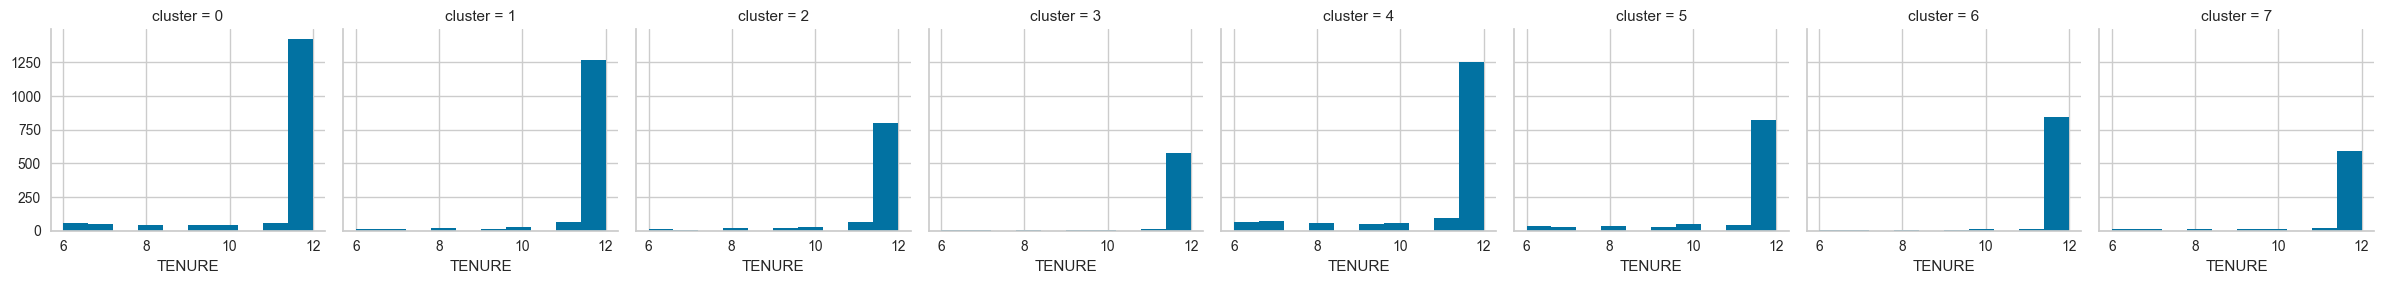

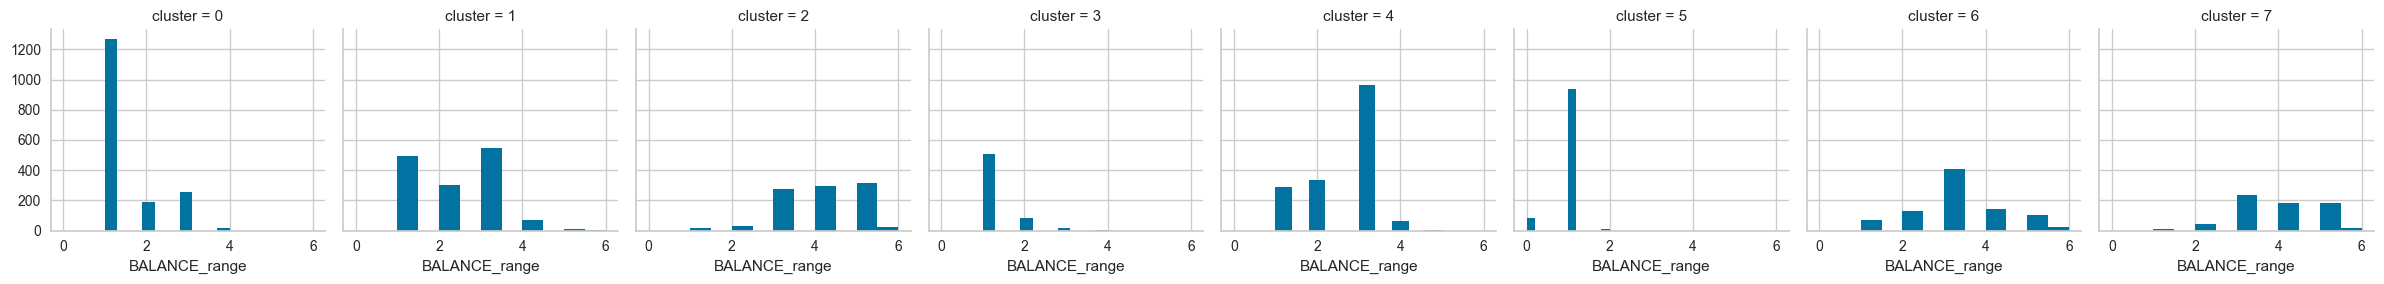

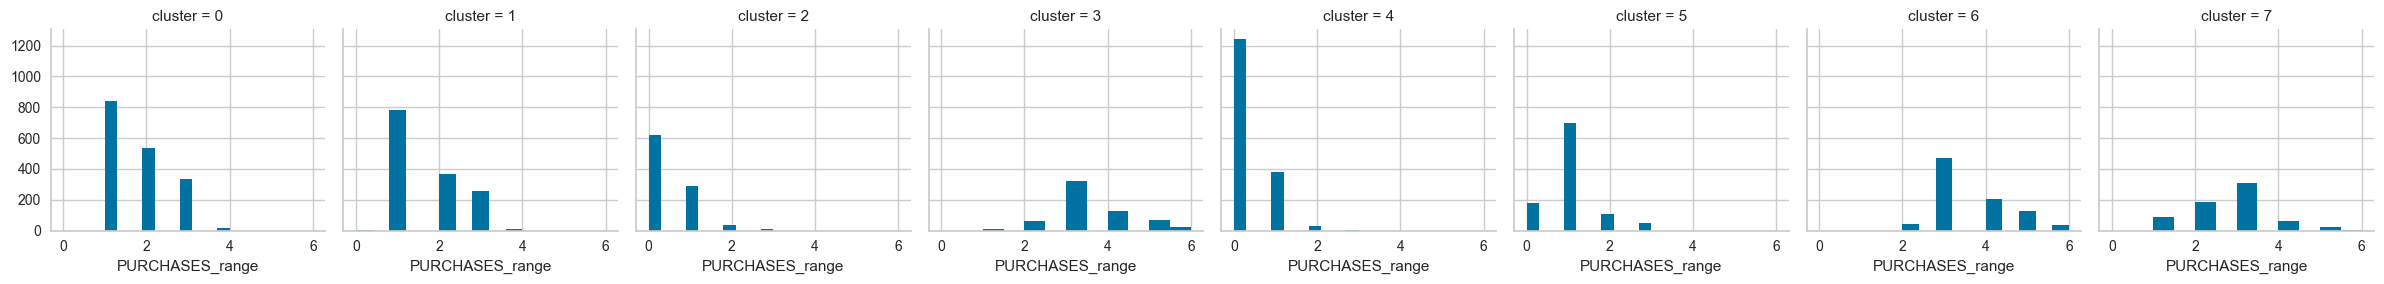

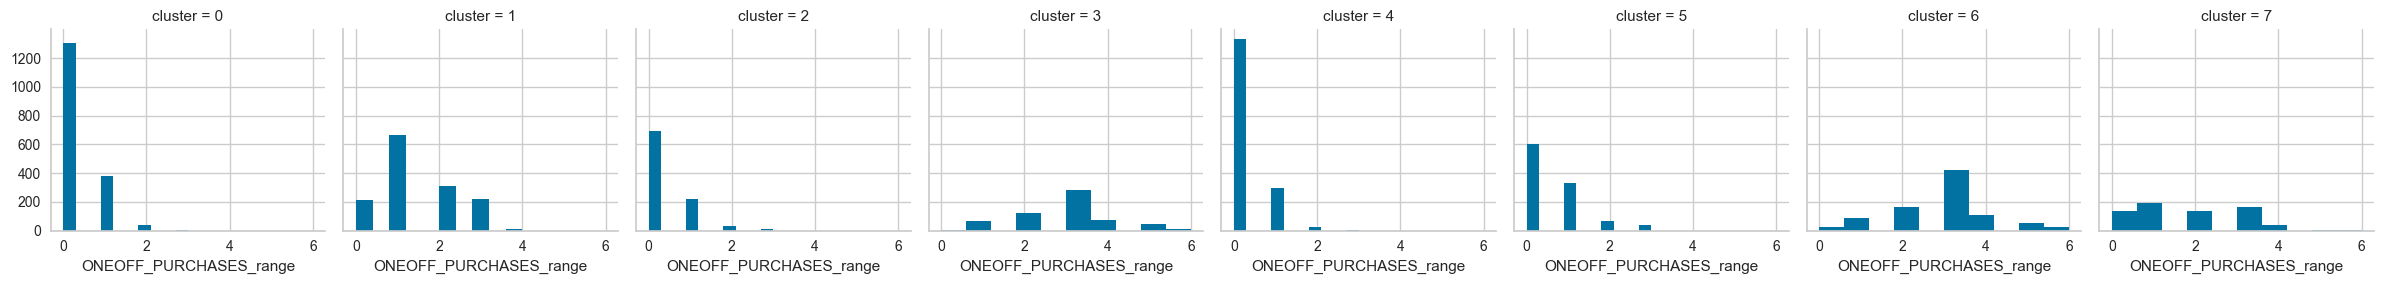

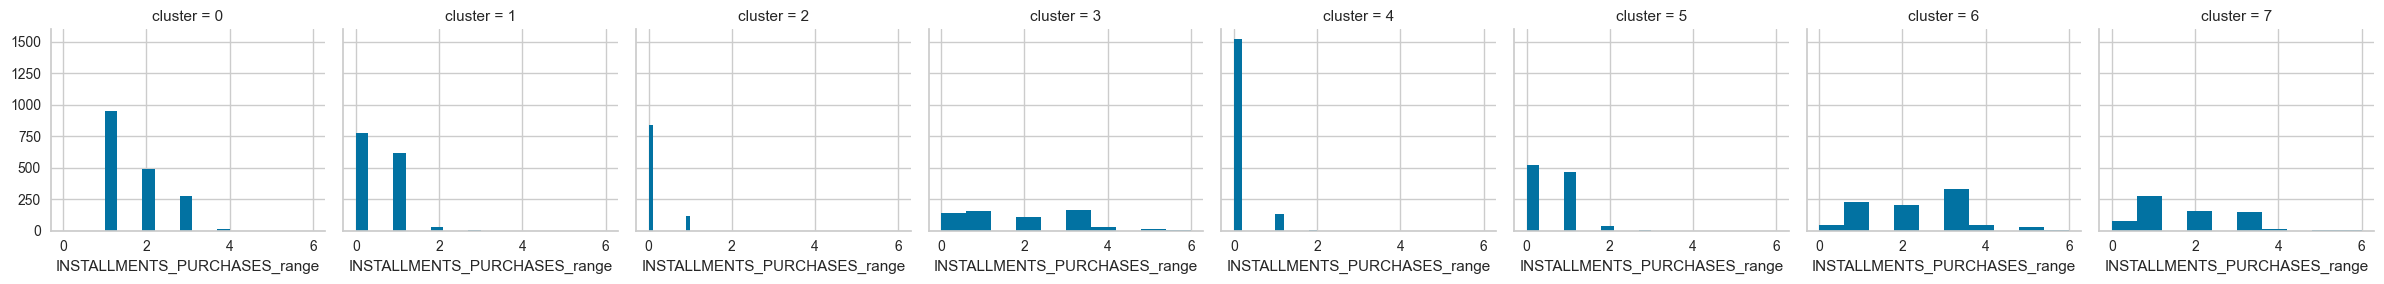

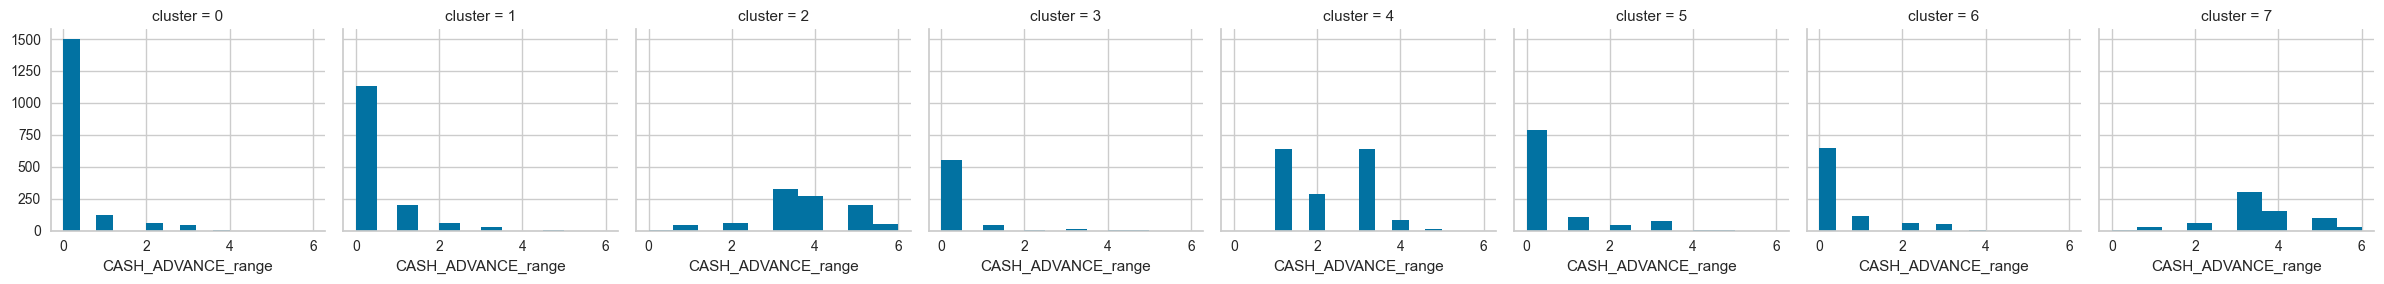

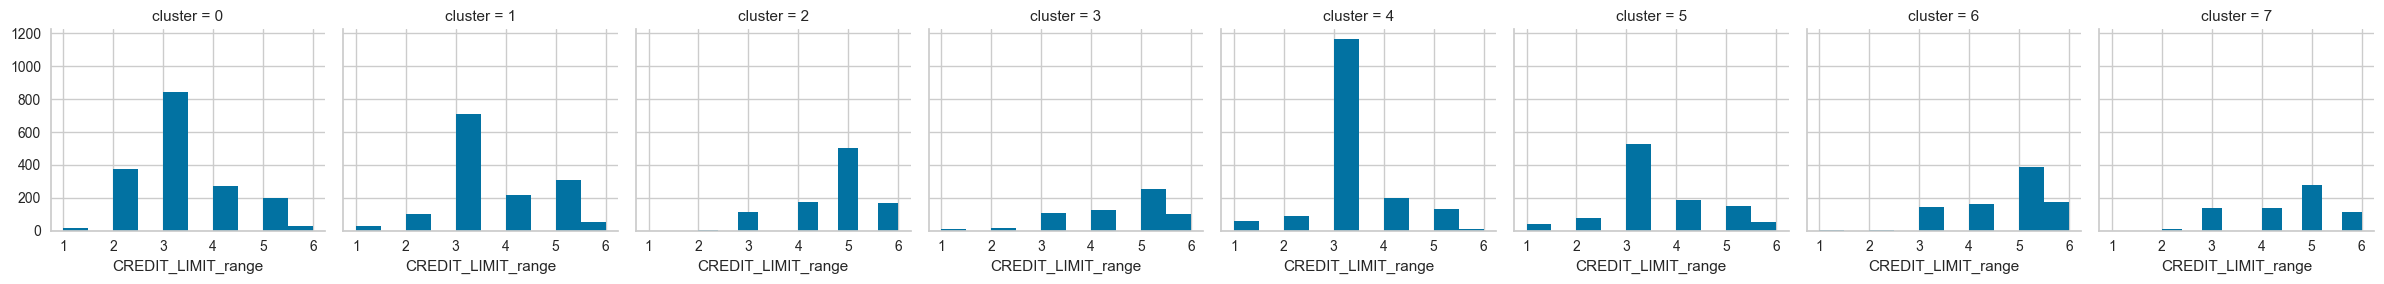

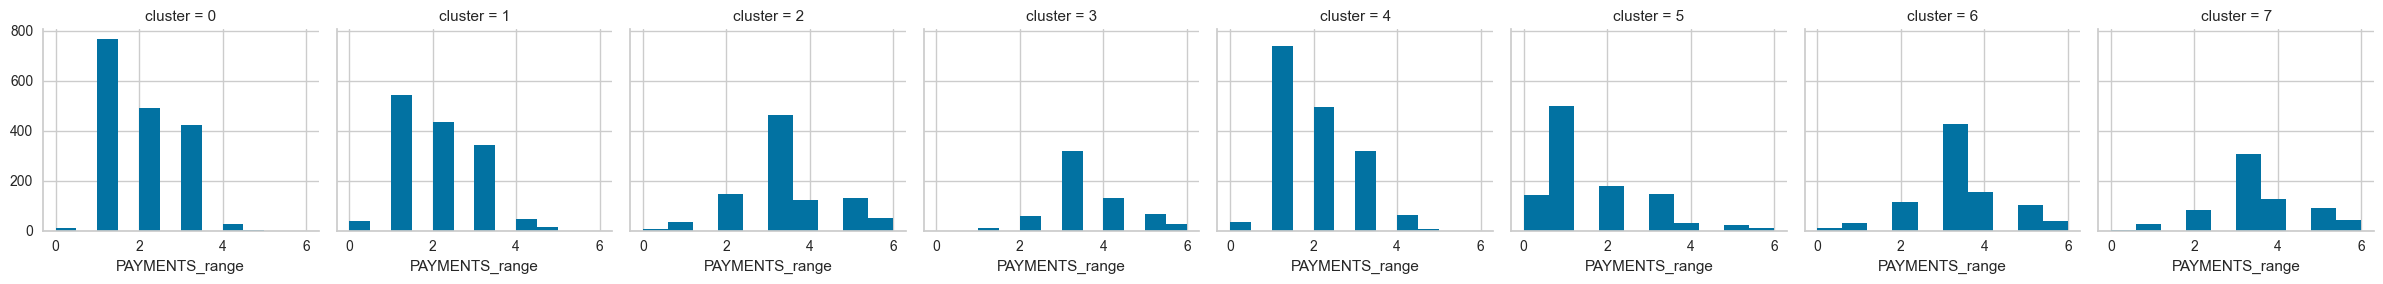

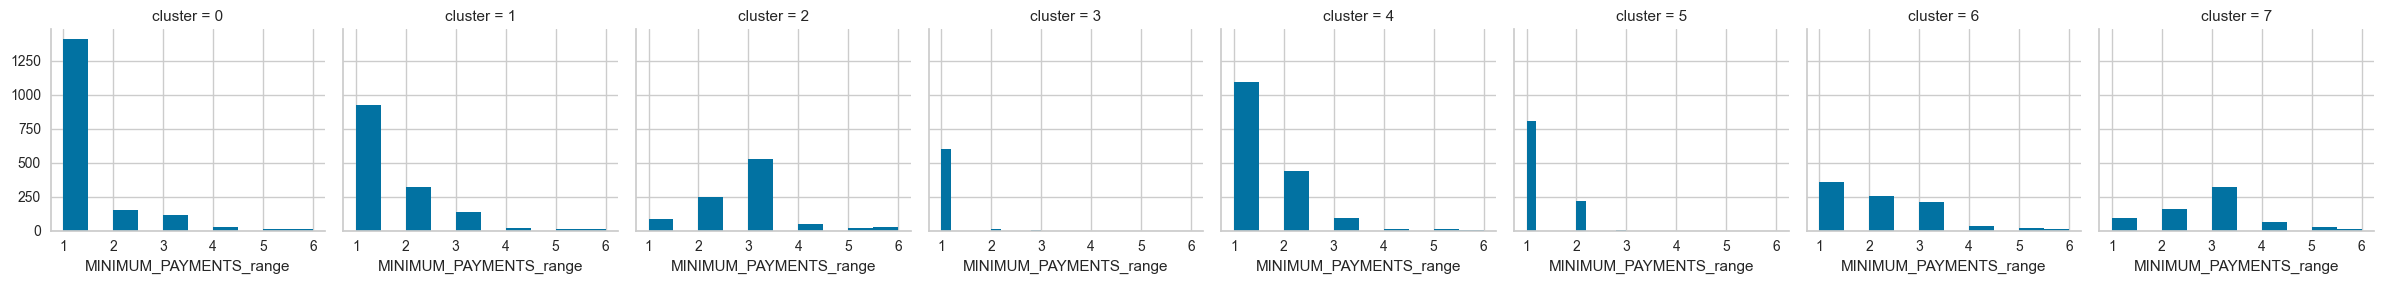

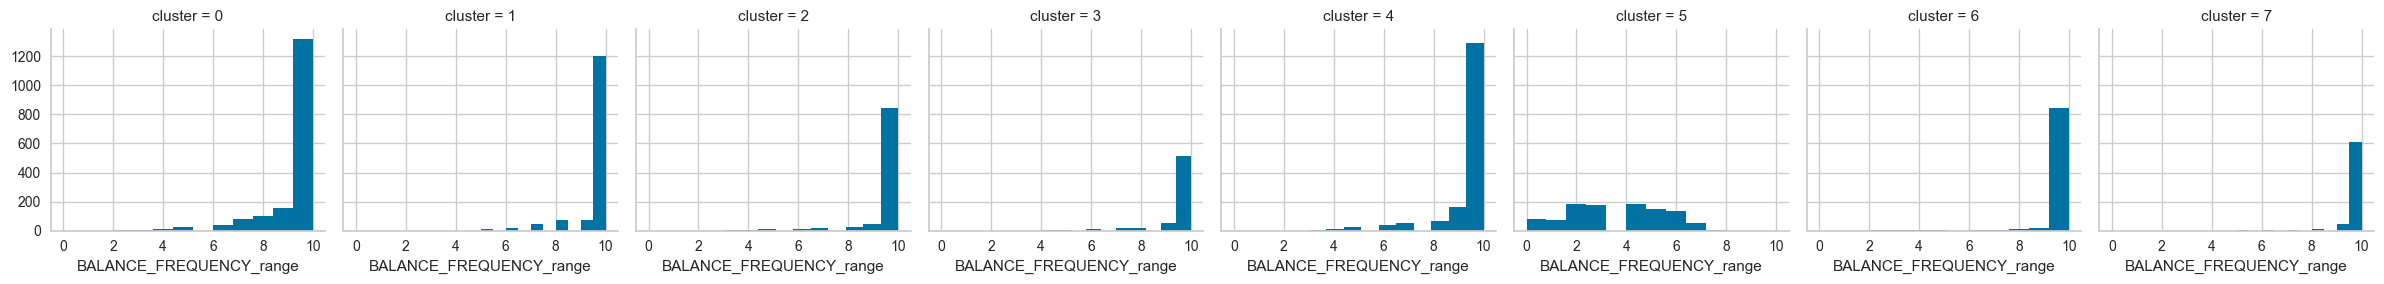

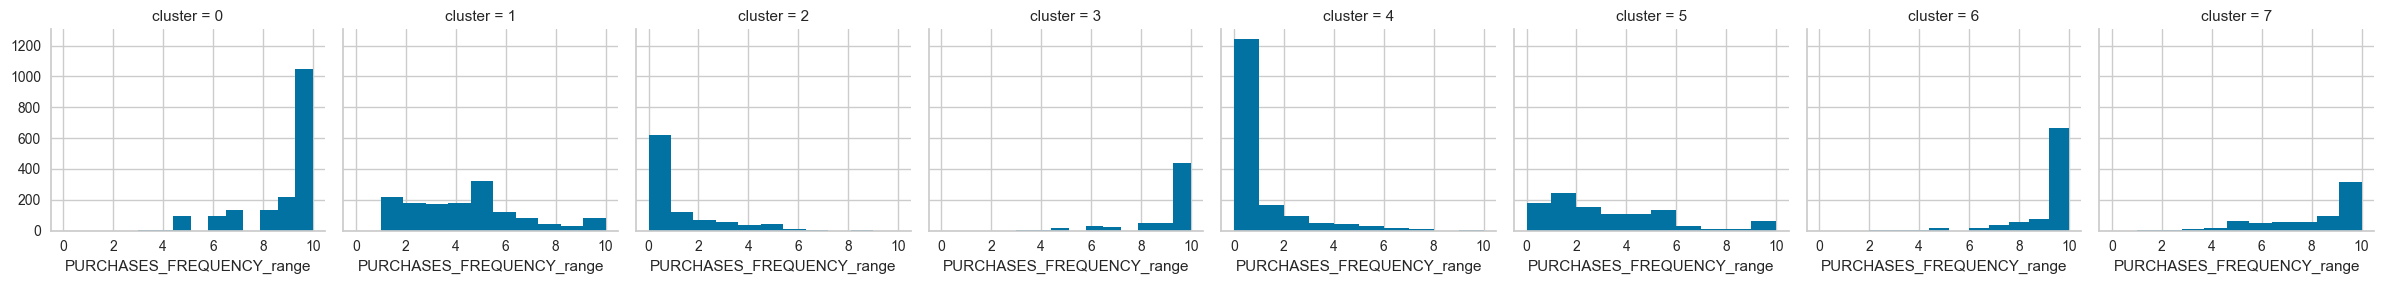

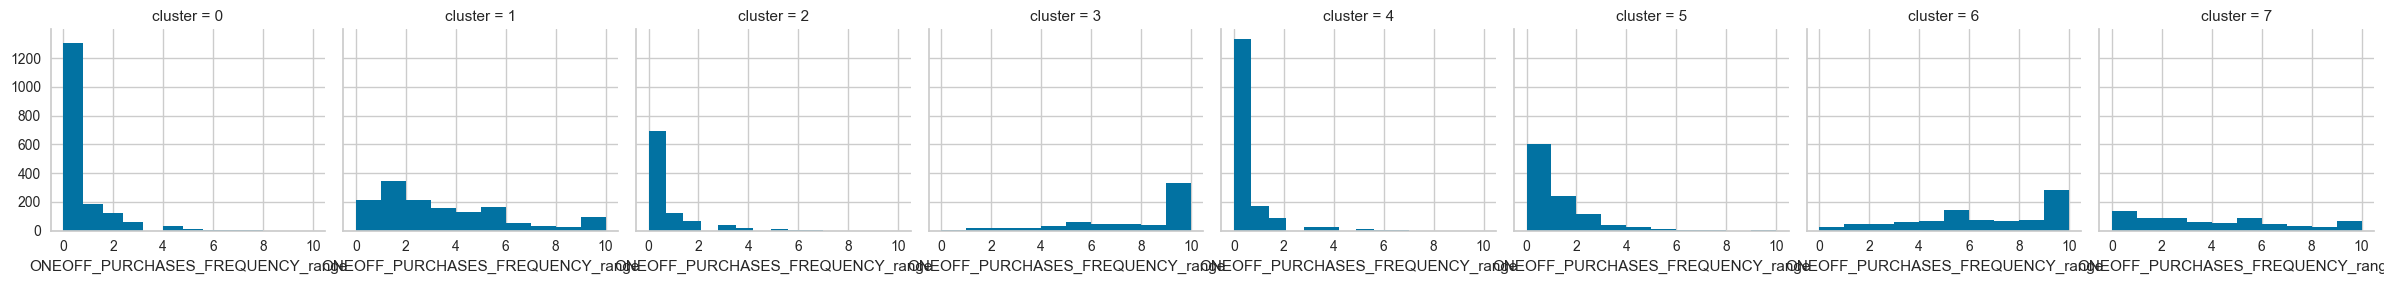

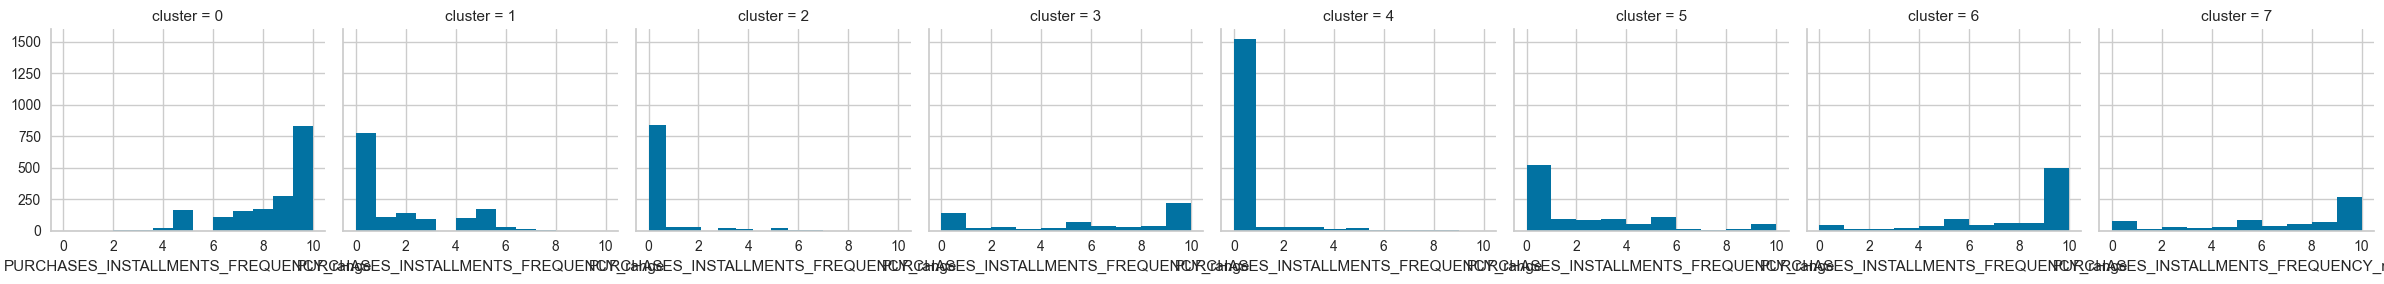

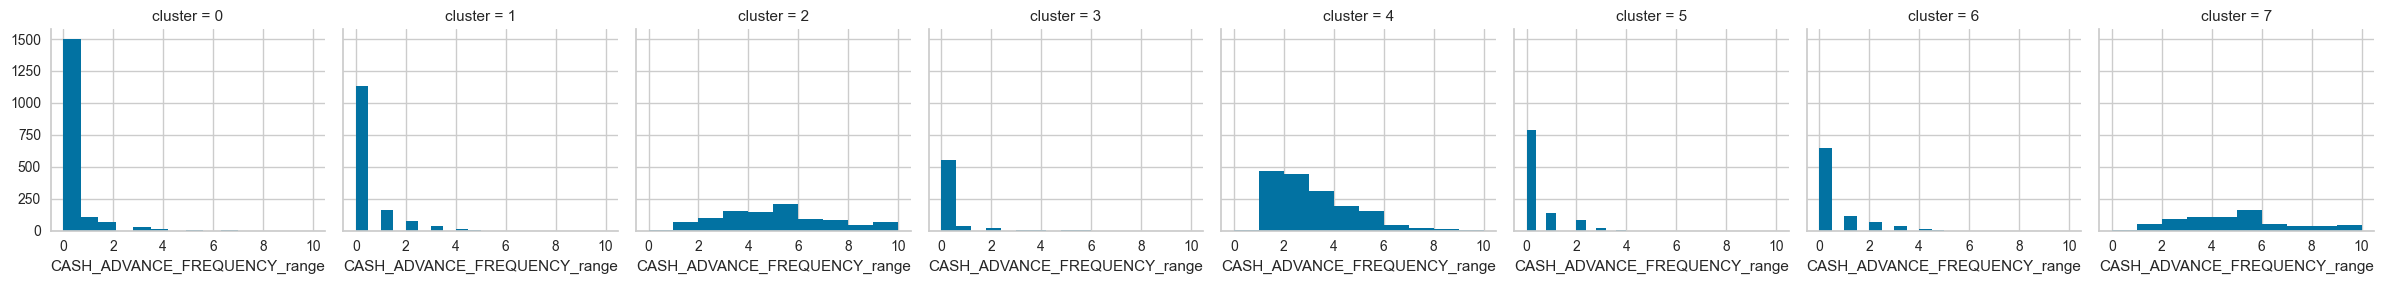

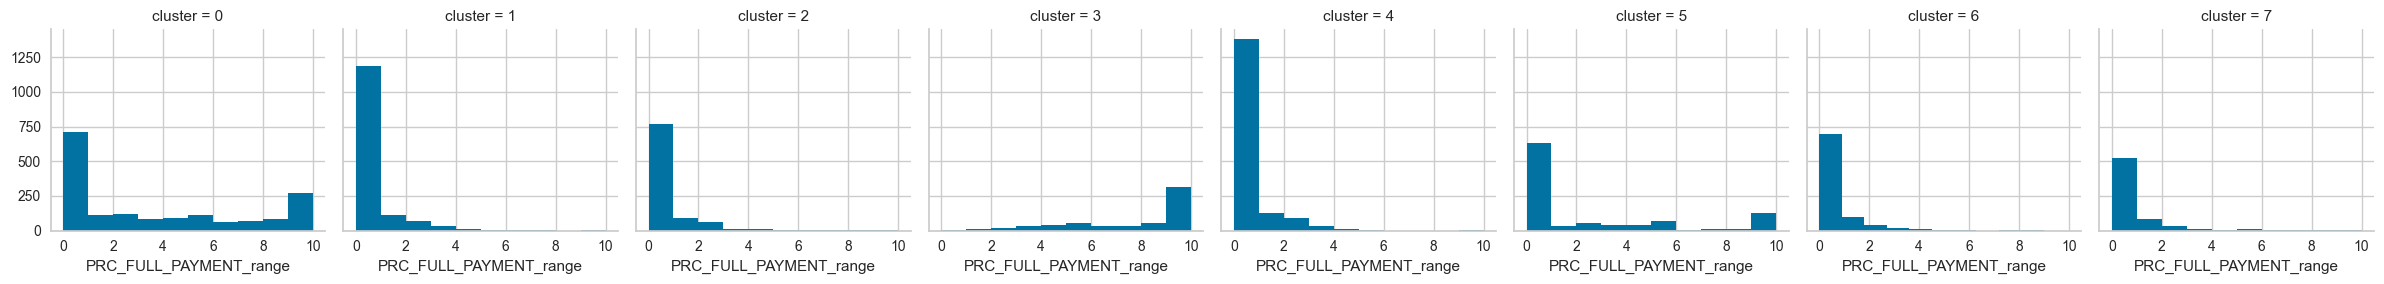

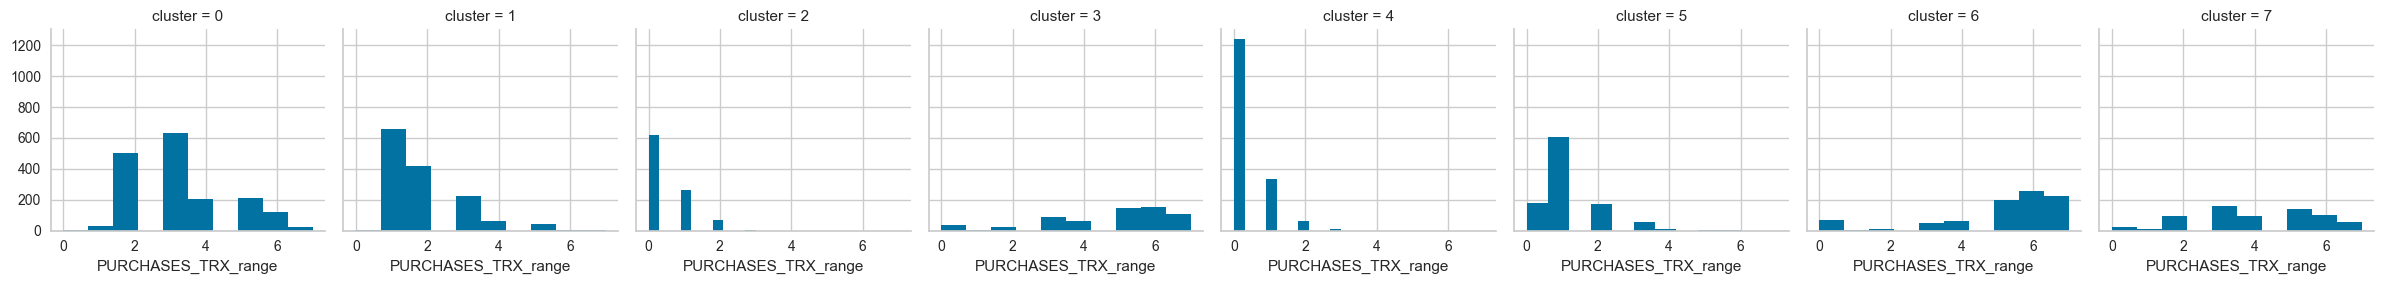

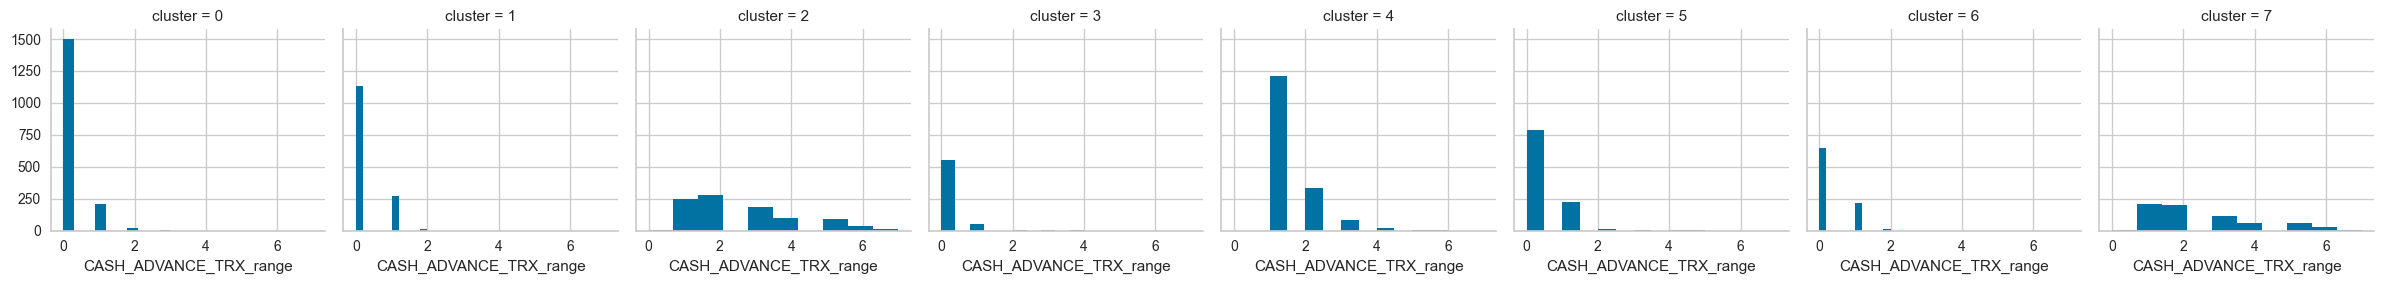

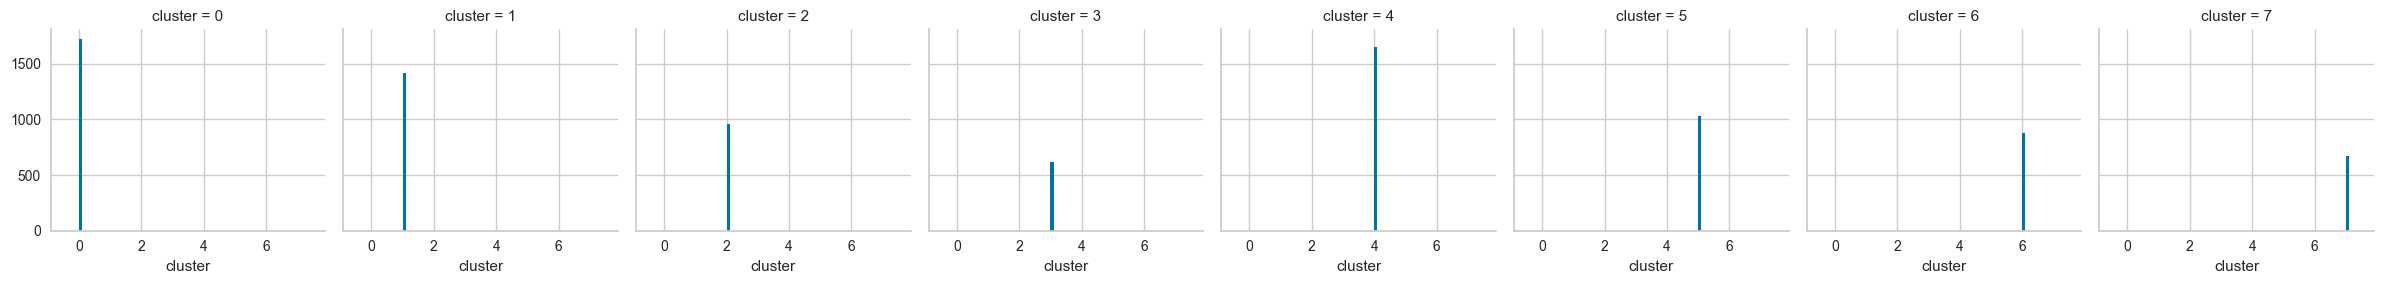

In [52]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

In [53]:
pca = PCA(2)
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

(8950, 2)

In [59]:
pca.explained_variance_ratio_

array([0.31642559, 0.22163255])

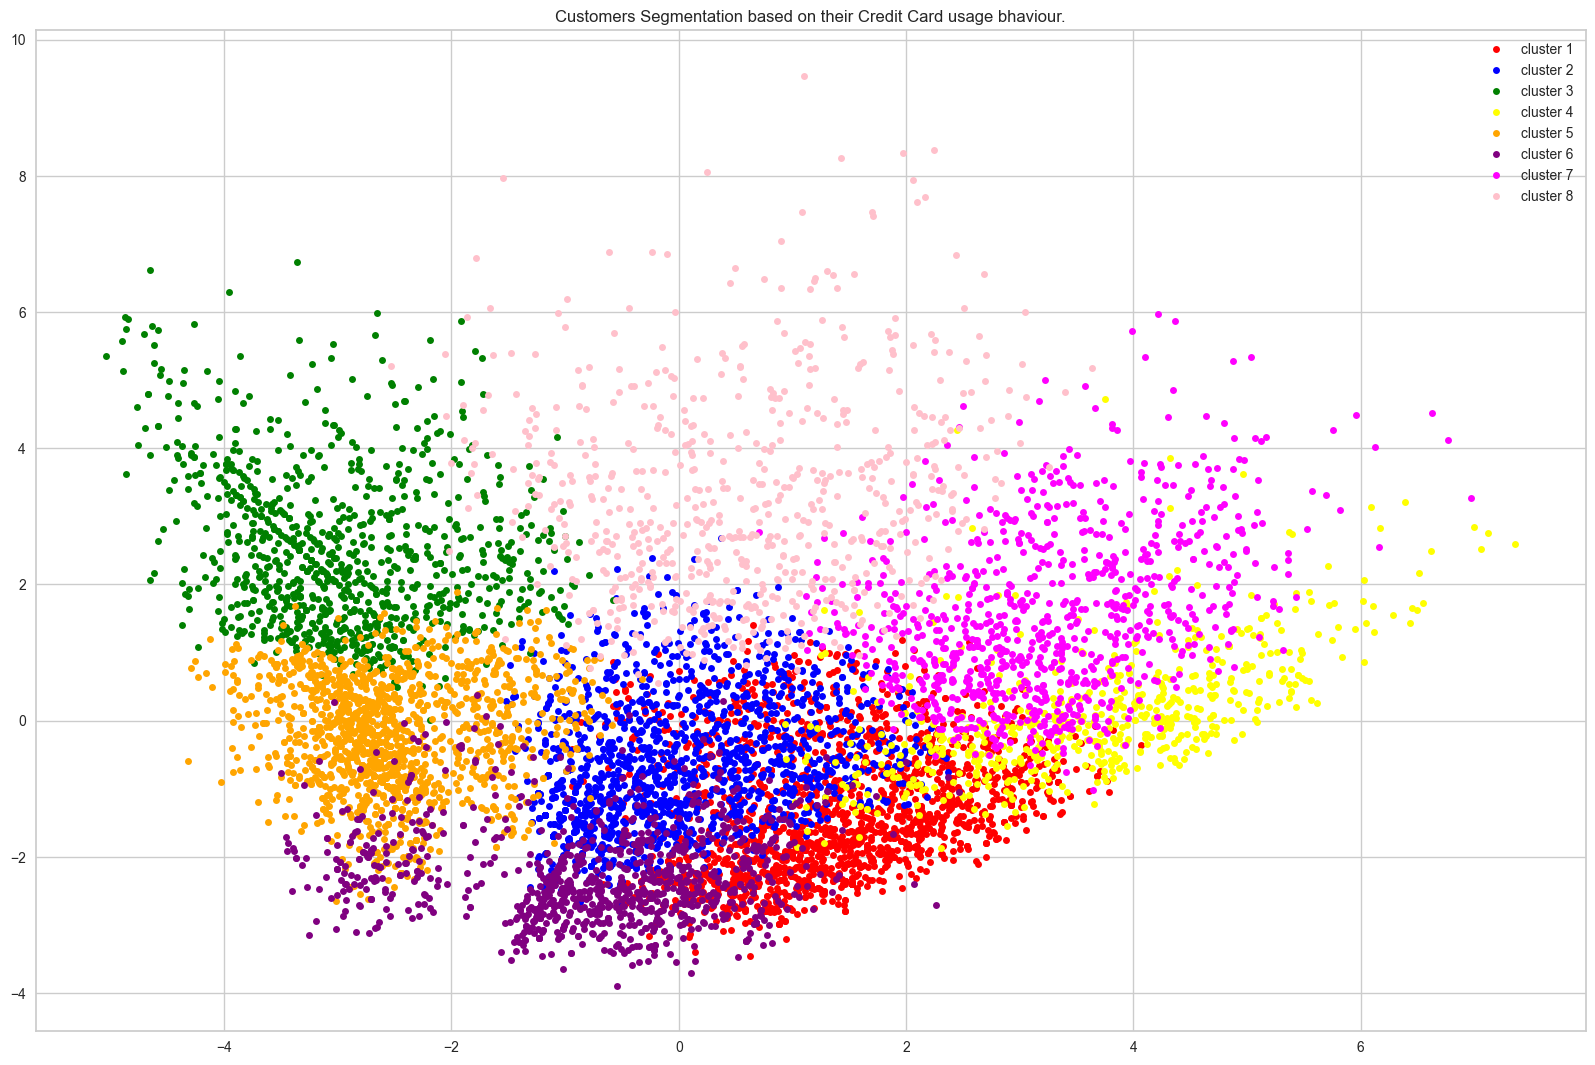

In [63]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple',
          6:'fuchsia',
          7:'pink'}

names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

def cos_dist(X):
     return 1 - cosine_similarity(X) 

In [67]:
dist =cos_dist(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

In [68]:
pca.explained_variance_ratio_

array([0.56896754, 0.2515564 ])

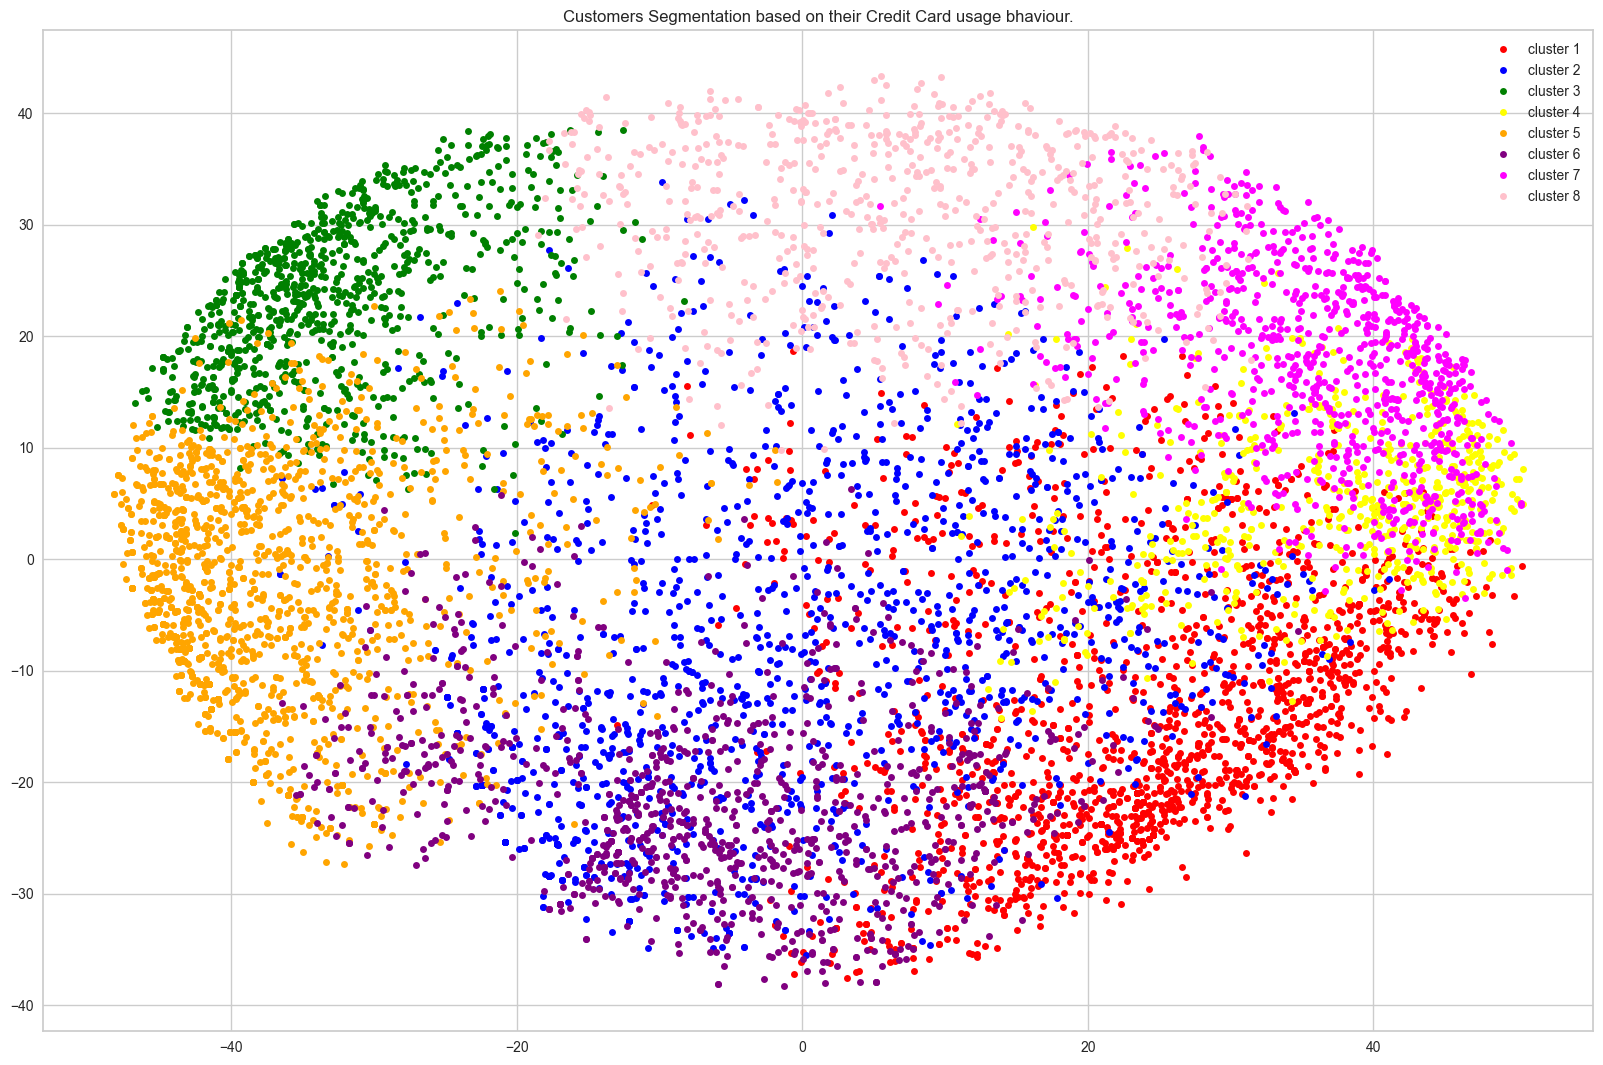

In [69]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple',
          6:'fuchsia',
          7:'pink'}

names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()